<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/tf_cnn_lstm5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.54.147.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.54.147.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.54.147.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
X=np.load("/content/gdrive/MyDrive/hand sign database array X.npy")
Y=np.load("/content/gdrive/MyDrive/hand sign database array Y.npy")

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as tfKL
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import pandas as pd

nLookback=4
height=50
width=50
channels=3
nCategories=8

In [5]:
#HERE WE WILL FIRST TRY TO DEAL WITH OVERFITTING AND UNDERFITTING BY PLAYING AROUND WITH THE HYPERPARAMETERS

In [7]:
def sameLists(l1,l2):
  i=0
  for li1 in l1:
    j=0
    for li2 in li1:
      change=l1[i][j]-l2[i][j]
      answer=np.count_nonzero(change)
      if answer>0:
        return False
      j+=1
    i+=1
  return True

In [33]:
def createModel(dropoutsRates=list((0.5,0.5,0.5))):
  with tpu_strategy.scope():
    model=tf.keras.Sequential()
    model.add(tfKL.TimeDistributed(tfKL.Conv2D(filters=64,kernel_size=(3,3),activation='relu',trainable=True),input_shape=(None,nLookback,height,width,channels)))
    model.add(tfKL.TimeDistributed(tfKL.Dropout(dropoutsRates[0],trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Conv2D(filters=64,kernel_size=(3,3),activation='relu',trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Dropout(dropoutsRates[1],trainable=True)))

    model.add(tfKL.TimeDistributed(tfKL.MaxPooling3D(pool_size=(2,2,2),trainable=True)))
    model.add(tfKL.TimeDistributed(tfKL.Flatten(trainable=True)))


    model.add(tfKL.LSTM(units=100,activation='tanh',trainable=True))
    model.add(tfKL.Dropout(dropoutsRates[2],trainable=True))
    model.add(tfKL.Dense(units=100,activation='relu',trainable=True))
    model.add(tfKL.Dense(units=nCategories,activation='softmax',trainable=True))
    model.compile(metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam')
    return model

In [34]:
#first just playing with the dropout rates

In [35]:
def evaluateModel(X,Y,nSubsequences=5,nLookback=4,nCategories=8,train_size=0.8,verbose=0,epochs=30,val_prop=0.2223,dropoutsRates=list((0.5,0.5,0.5))):
  with tpu_strategy.scope():
    trainX, testX, trainY, testY = train_test_split(X, Y, train_size=train_size, random_state=random.randint(1,100000))
  
  verbose=verbose
  epochs=epochs
  batch_size=10

  
  height=trainX.shape[2]
  width=trainX.shape[3]
  channels=trainX.shape[4]
  trainX=trainX.reshape((trainX.shape[0],nSubsequences,nLookback,trainX.shape[2],trainX.shape[3],trainX.shape[4]))
  testX=testX.reshape((testX.shape[0],nSubsequences,nLookback,testX.shape[2],testX.shape[3],testX.shape[4]))
  trainY=tf.keras.utils.to_categorical(trainY)
  testY=tf.keras.utils.to_categorical(testY)
  accuracy=0
  model=createModel(dropoutsRates=dropoutsRates)
  with tpu_strategy.scope():
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_split =val_prop)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    _,accuracy=model.evaluate(testX,testY,verbose=0,batch_size=batch_size)
  return accuracy

In [36]:
def summarizeScores(scores):
  print("Scores: ",scores)
  m,s=np.mean(scores),np.std(scores)
  x=[i for i in range(np.shape(scores)[0])]
  plt.plot(x,scores)
  
  plt.xlabel('Run')
  plt.ylabel('Accuracy')
  
  plt.show()
  print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [45]:
def runExperiments(X,Y,train_size=0.8,run=10,epochs=30,verbose=0,val_prop=0.2223,dropoutsRates=list((0.5,0.5,0.5))):#weights are changing for each run in experiment we can transfer weights accross experiments too but we are not doing that right now
  scores=list()
  for r in range(run):
    score=evaluateModel(X=X,Y=Y,train_size=train_size,epochs=epochs,val_prop=val_prop,dropoutsRates=dropoutsRates)
    score*=100.0
    scores.append(score)
    print('>#%d: %.3f' % (r+1, score))
  summarizeScores(scores)
  print("--------------------------------------------------------------------------------------------------------------------------")

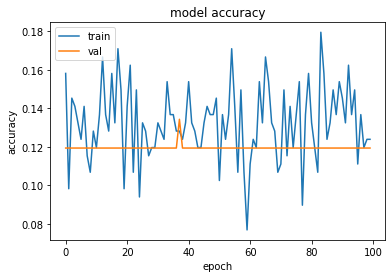

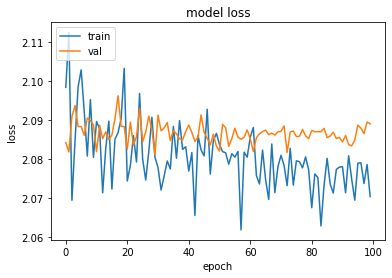

>#1: 10.891


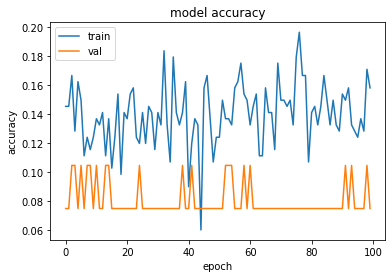

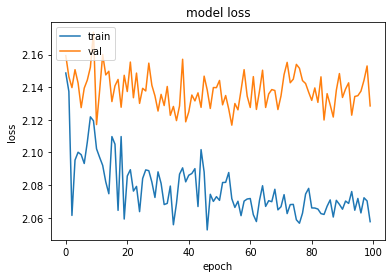

>#2: 10.891


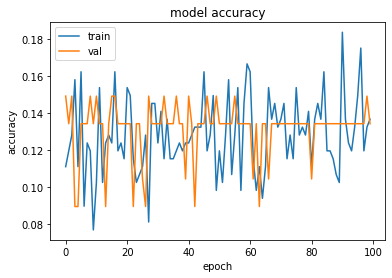

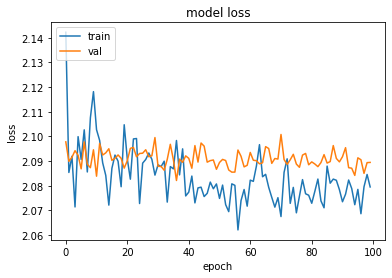

>#3: 8.911


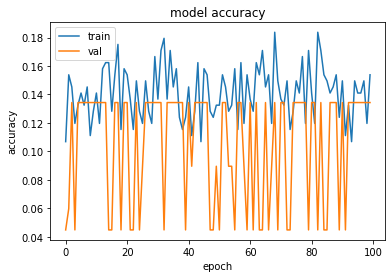

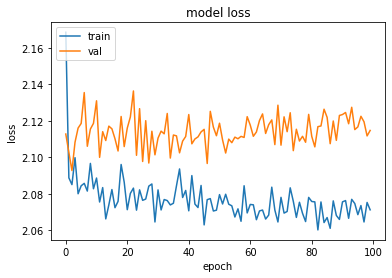

>#4: 6.931


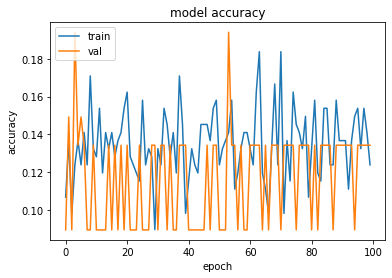

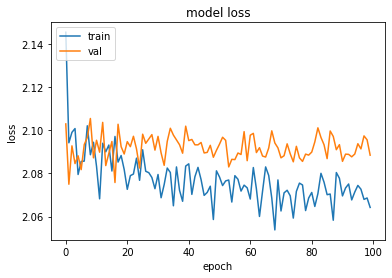

>#5: 8.911


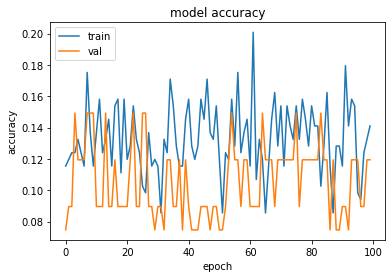

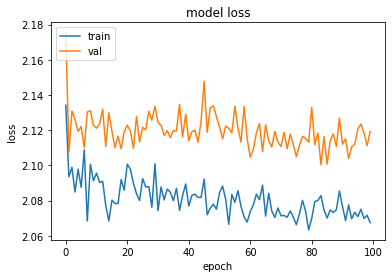

>#6: 9.901


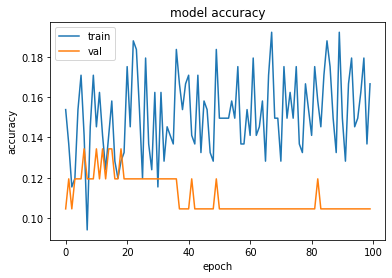

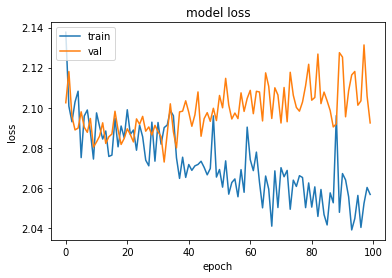

>#7: 8.911


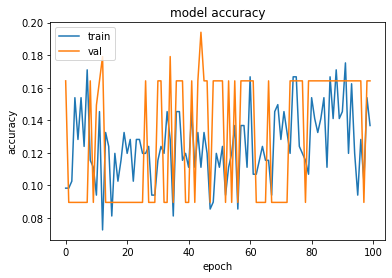

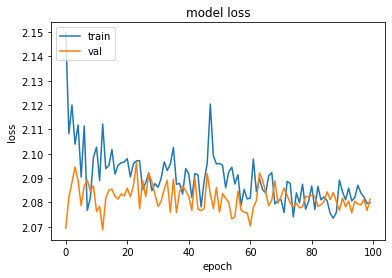

>#8: 7.921


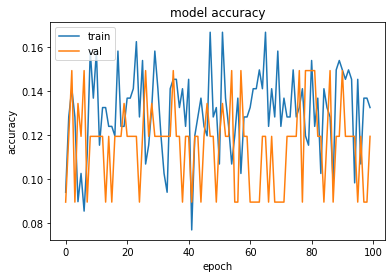

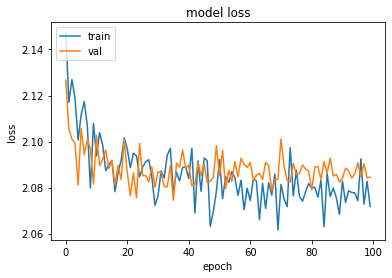

>#9: 8.911


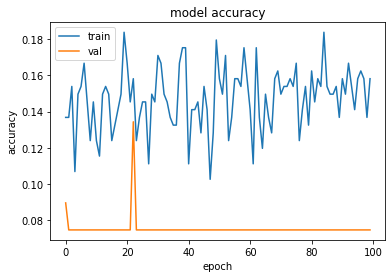

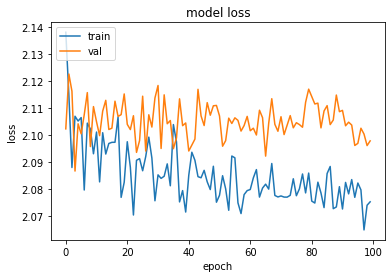

>#10: 9.901
Scores:  [10.891088843345642, 10.891088843345642, 8.9108906686306, 6.9306932389736176, 8.9108906686306, 9.90099012851715, 8.9108906686306, 7.920791953802109, 8.9108906686306, 9.90099012851715]


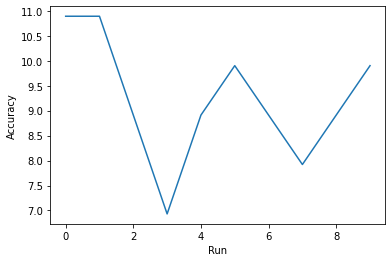

Accuracy: 9.208% (+/-1.176)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


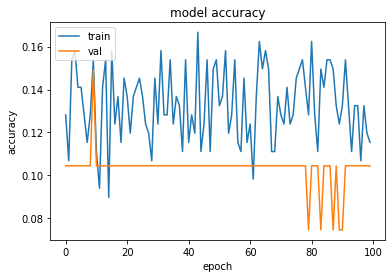

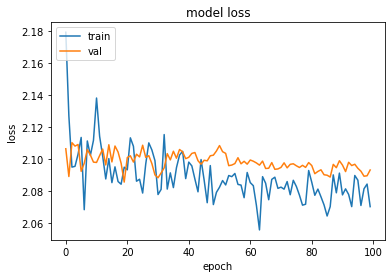

>#1: 9.901


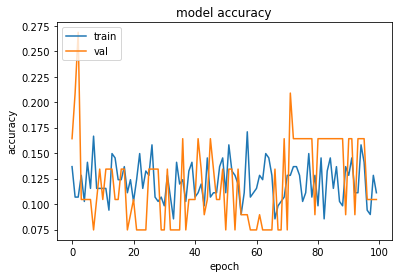

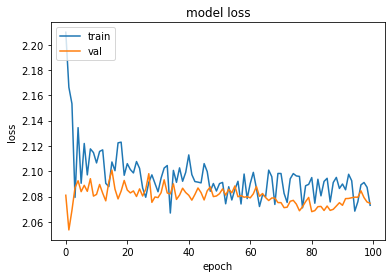

>#2: 13.861


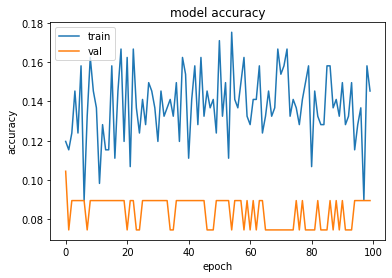

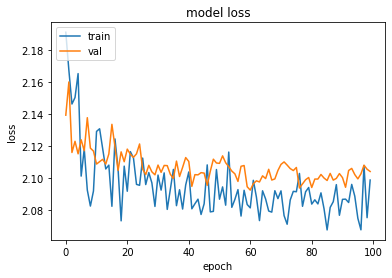

>#3: 12.871


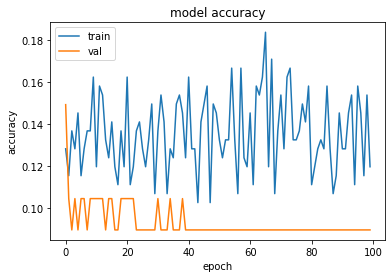

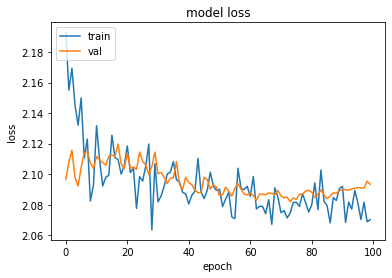

>#4: 11.881


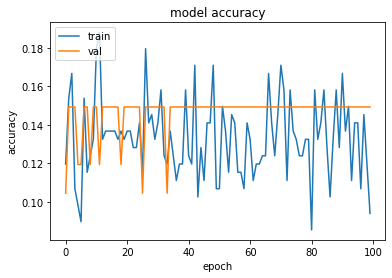

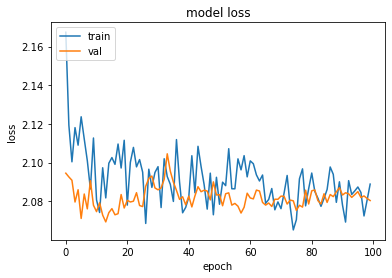

>#5: 6.931


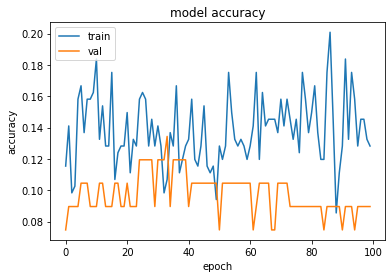

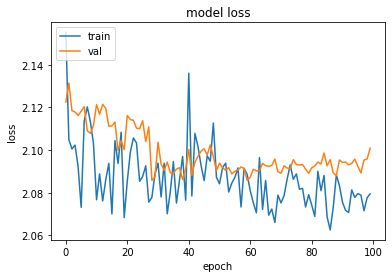

>#6: 11.881


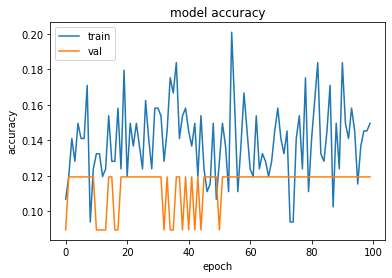

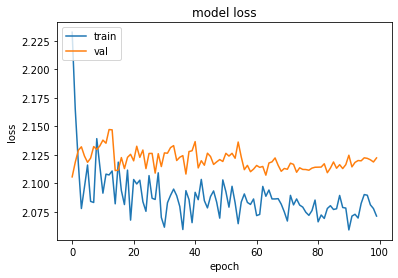

>#7: 7.921


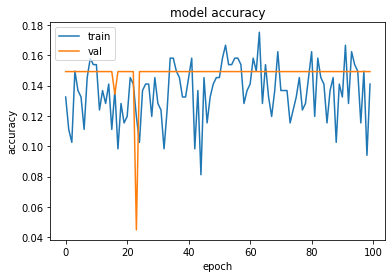

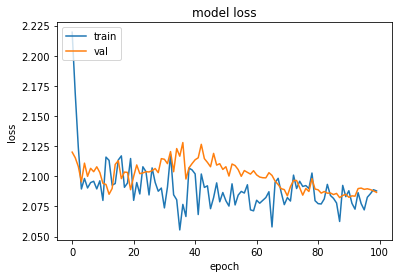

>#8: 6.931


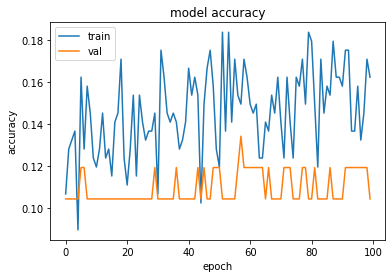

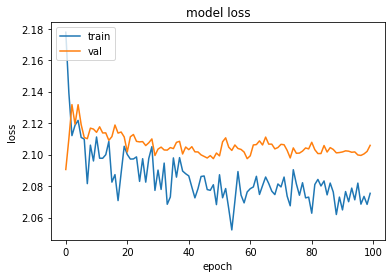

>#9: 6.931


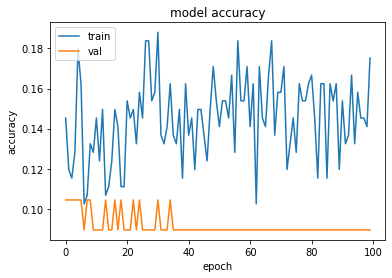

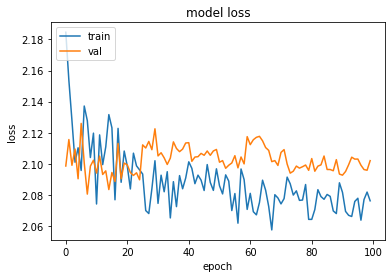

>#10: 7.921
Scores:  [9.90099012851715, 13.861386477947235, 12.871286273002625, 11.881187558174133, 6.9306932389736176, 11.881187558174133, 7.920791953802109, 6.9306932389736176, 6.9306932389736176, 7.920791953802109]


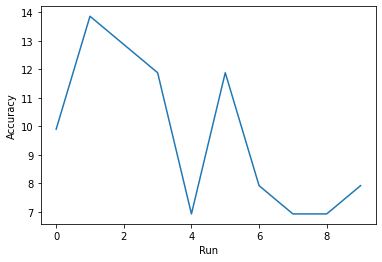

Accuracy: 9.703% (+/-2.574)
--------------------------------------------------------------------------------------------------------------------------


In [48]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=10,epochs=100,dropoutsRates=list((0.2,0.2,0.2)))
  print("-------------------------------------------")
  runExperiments(X,Y,train_size=0.75,run=10,epochs=100,dropoutsRates=list((0.5,0.5,0.5)))

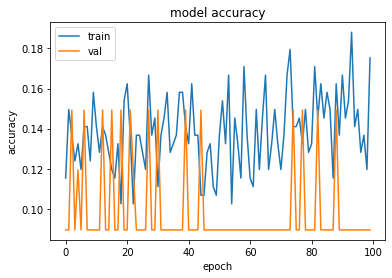

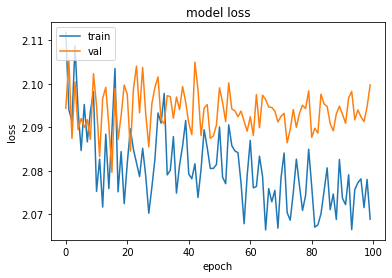

>#1: 7.921


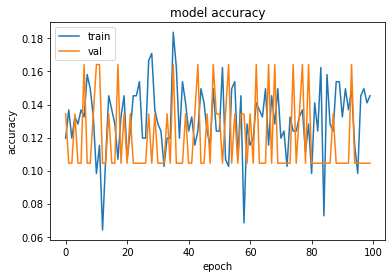

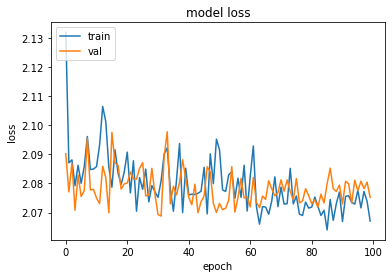

>#2: 11.881


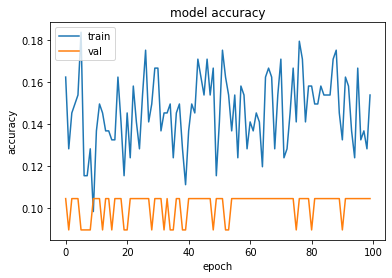

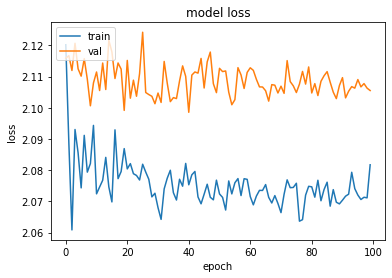

>#3: 7.921


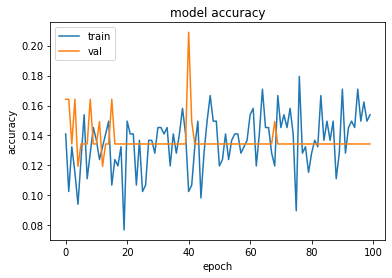

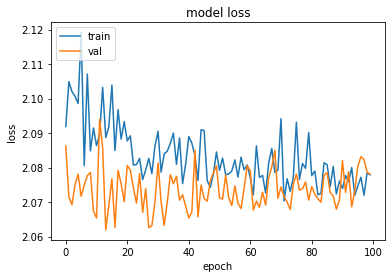

>#4: 7.921


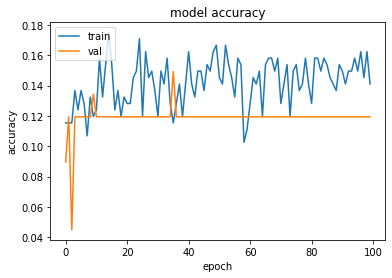

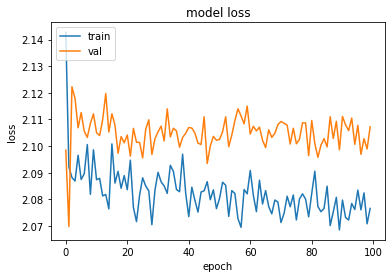

>#5: 7.921
Scores:  [7.920791953802109, 11.881187558174133, 7.920791953802109, 7.920791953802109, 7.920791953802109]


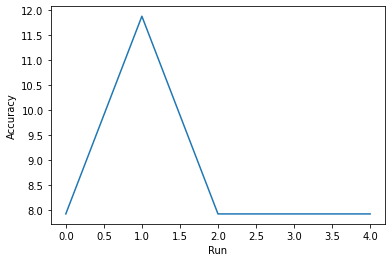

Accuracy: 8.713% (+/-1.584)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [50]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.1,0.12,0.1)))
  print("-------------------------------------------")

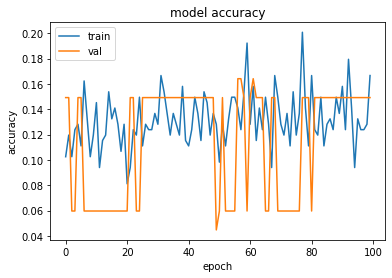

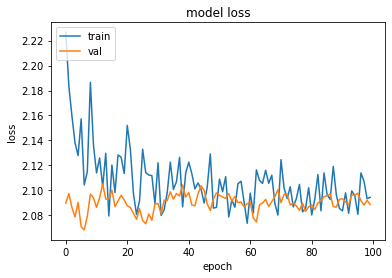

>#1: 9.901


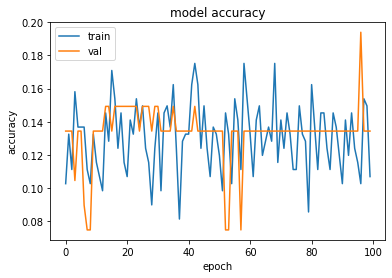

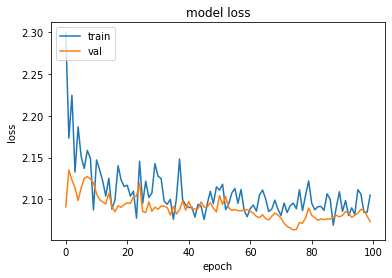

>#2: 8.911


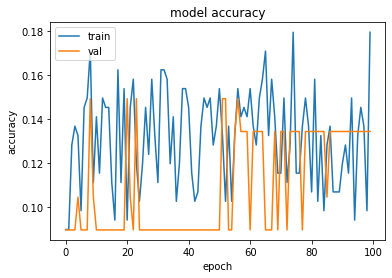

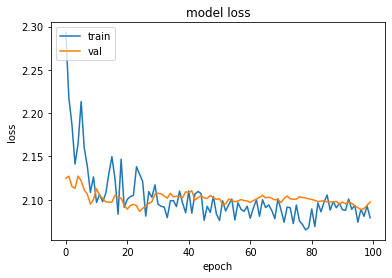

>#3: 13.861


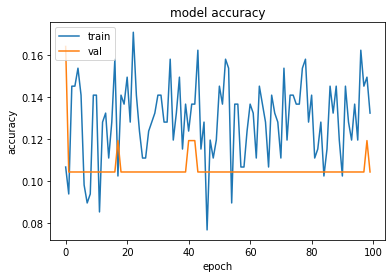

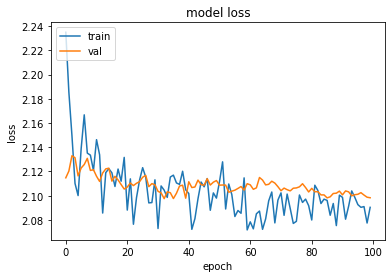

>#4: 9.901


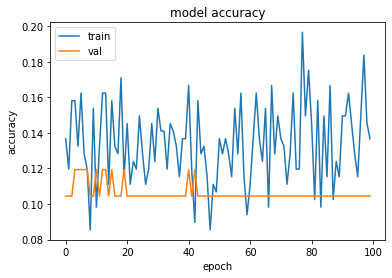

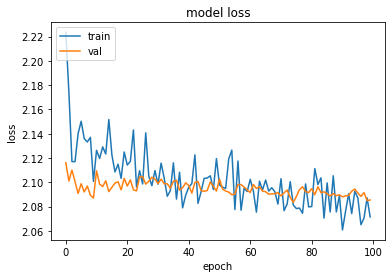

>#5: 9.901
Scores:  [9.90099012851715, 8.9108906686306, 13.861386477947235, 9.90099012851715, 9.90099012851715]


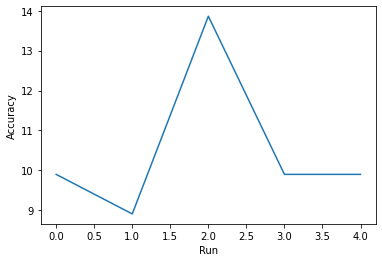

Accuracy: 10.495% (+/-1.726)
--------------------------------------------------------------------------------------------------------------------------
-------------------------------------------


In [51]:
with tpu_strategy.scope():
  runExperiments(X,Y,train_size=0.75,run=5,epochs=100,dropoutsRates=list((0.7,0.7,0.7)))
  print("-------------------------------------------")

In [49]:
'''clearly when we reduce the dropout we see that the problem of training curve starting above of validation curve reduces
this indicates that underfitting does take place
but we can also see that it creates scope for poor performance on the val set which means that overfitting is there as well
Thus our model seems to have overfitting as well as underfitting
When the dropout is high there is a lot of underfitting consequences but we have removed the OVERFITTING issue
when it is low we reduce the underfitting ISSUE but the overfitting takes place
My next step would be to try to reduce overfitting by adding regularization and reduce underfitting by making the model deeper and more complex
''''